In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [64]:
# Cargar el archivo CSV
file_path = 'D:\DESK\PATRONUS\merged_dataset_balanced.csv'
df = pd.read_csv(file_path, sep=';')

# Mostrar las primeras filas del dataframe para entender su estructura
df.head()


C:\Users\FABRICIO\AppData\Local\Temp\ipykernel_18788\1859197316.py:3: DtypeWarning: Columns (12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';')


,Subject Number,Age,Gender,Height [cm],Weight [kg],PEEP,COPD,Time [s],Pressure [cmH2O],Flow [L/s],V_tidal [L],History of Smoking (yes/no),Smoking Frequency,History of vaping (yes/no),Frequency of vaping,Asthma (yes/no and severity)
0,1,24,Female,160-169,65,0,0,0.00,2.681998,-0.577100,0.000000,No,NaN,No,NaN,No
1,1,24,Female,160-169,65,0,0,0.01,2.617630,-0.597392,-0.005872,No,NaN,No,NaN,No
2,1,24,Female,160-169,65,0,0,0.02,2.681998,-0.597392,-0.011846,No,NaN,No,NaN,No
3,1,24,Female,160-169,65,0,0,0.03,2.617630,-0.626598,-0.017966,No,NaN,No,NaN,No
4,1,24,Female,160-169,65,0,0,0.04,2.649814,-0.626598,-0.024232,No,NaN,No,NaN,No


In [65]:
# Agrupar por 'subject number', 'copd' y 'peep'
grouped = df.groupby(['Subject Number', 'COPD', 'PEEP'])

# Función para extraer características de las señales
def extract_features(group):
    features = {}
    features['mean_pressure'] = group['Pressure [cmH2O]'].mean()
    features['std_pressure'] = group['Pressure [cmH2O]'].std()
    features['min_pressure'] = group['Pressure [cmH2O]'].min()
    features['max_pressure'] = group['Pressure [cmH2O]'].max()
    features['mean_flow'] = group['Flow [L/s]'].mean()
    features['std_flow'] = group['Flow [L/s]'].std()
    features['min_flow'] = group['Flow [L/s]'].min()
    features['max_flow'] = group['Flow [L/s]'].max()
    features['mean_v_tidal'] = group['V_tidal [L]'].mean()
    features['std_v_tidal'] = group['V_tidal [L]'].std()
    features['min_v_tidal'] = group['V_tidal [L]'].min()
    features['max_v_tidal'] = group['V_tidal [L]'].max()
    # Agregar características adicionales según sea necesario
    return pd.Series(features)

# Aplicar la función de extracción de características a cada grupo
features_df = grouped.apply(extract_features).reset_index()

# Agregar las columnas de metadatos al nuevo dataframe
metadata_columns = ['Age', 'Gender', 'Height [cm]', 'Weight [kg]', 'History of Smoking (yes/no)', 
                    'Smoking Frequency', 'History of vaping (yes/no)', 'Frequency of vaping', 'Asthma (yes/no and severity)']
metadata_df = df.groupby(['Subject Number', 'COPD', 'PEEP'])[metadata_columns].first().reset_index()

# Combinar las características extraídas con los metadatos
final_df = pd.merge(features_df, metadata_df, on=['Subject Number', 'COPD', 'PEEP'])

# Mostrar las primeras filas del nuevo dataframe
final_df.head()


,Subject Number,COPD,PEEP,mean_pressure,std_pressure,min_pressure,max_pressure,mean_flow,std_flow,min_flow,...,max_v_tidal,Age,Gender,Height [cm],Weight [kg],History of Smoking (yes/no),Smoking Frequency,History of vaping (yes/no),Frequency of vaping,Asthma (yes/no and severity)
0,1,0,0,-0.278586,3.058327,-5.642923,3.797709,0.001569,0.670624,-0.845197,...,1.295013,24,Female,160-169,65,No,None,No,None,No
1,1,0,4,1.730751,2.677209,-3.368589,6.104227,0.015558,0.889776,-1.139405,...,0.888420,24,Female,160-169,65,No,None,No,None,No
2,1,0,8,3.840394,3.160235,-2.478166,8.271281,-0.031000,1.236721,-1.496532,...,1.155625,24,Female,160-169,65,No,None,No,None,No
3,1,200,0,14.973794,10.000948,-10.770902,26.905800,0.003706,0.503923,-0.938713,...,0.750859,24,Female,160-169,65,No,None,No,None,No
4,1,200,4,15.413399,8.261173,-11.779333,29.898909,-0.034751,0.607168,-1.085856,...,1.413675,24,Female,160-169,65,No,None,No,None,No


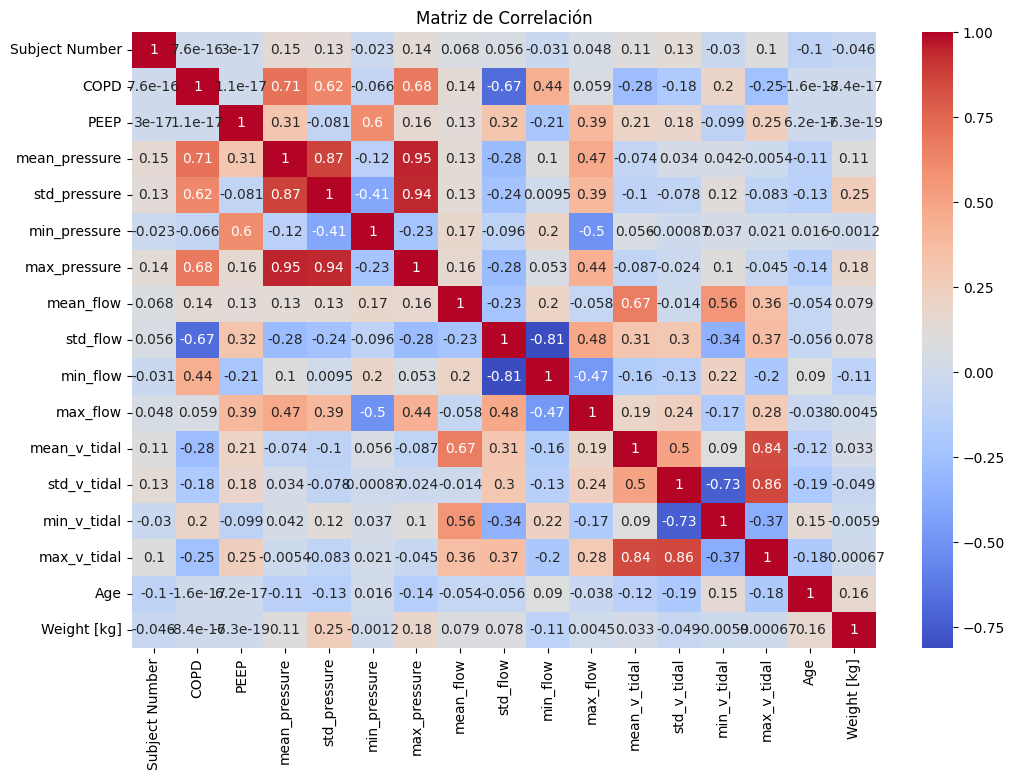

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas para el cálculo de la correlación
numeric_cols = final_df.select_dtypes(include=['float64', 'int64']).columns

# Visualización de la correlación entre características numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(final_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


In [67]:

# Separar características y etiquetas
X = final_df.drop(columns=['Subject Number', 'COPD', 'PEEP', 'Gender', 'Height [cm]', 
                           'History of Smoking (yes/no)', 'Smoking Frequency', 'History of vaping (yes/no)', 
                           'Frequency of vaping', 'Asthma (yes/no and severity)'])
y = final_df['COPD']  # Suponiendo que 'copd' es la etiqueta a predecir

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [68]:
# Lista de modelos y sus hiperparámetros para el tuning
models = [
    ('RandomForest', RandomForestClassifier(), {
        'model__n_estimators': [50, 100, 200],
        'model__max_features': ['auto', 'sqrt', 'log2']
    }),
    ('SVM', SVC(), {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf', 'poly']
    }),
    ('KNN', KNeighborsClassifier(), {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    }),
    ('DecisionTree', DecisionTreeClassifier(), {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }),
    ('NaiveBayes', GaussianNB(), {}),
    ('LogisticRegression', LogisticRegression(max_iter=10000), {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l2']
    }),
    ('MLP', MLPClassifier(max_iter=10000), {
        'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'model__activation': ['tanh', 'relu'],
        'model__solver': ['sgd', 'adam']
    })
]

# Entrenamiento y evaluación de los modelos
results = {}

for name, model, param_grid in models:
    # Definir el pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Realizar la búsqueda en la rejilla de hiperparámetros
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    results[name] = {
        'best_model': best_model,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'class_report': class_report
    }
    
    print(f"{name} Model Evaluation:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")
    print("---------------------------------------------------")

# Visualización de los resultados
for model_name, result in results.items():
    print(f"{model_name} Model:")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])
    print("---------------------------------------------------")


c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\FABRICIO\AppData\Local\Programs\Python\Python310\lib\

RandomForest Model Evaluation:
Best Parameters: {'model__max_features': 'log2', 'model__n_estimators': 200}
Accuracy: 0.4305555555555556
Confusion Matrix:
[[21  0  0  0]
 [ 0  5  5  5]
 [ 0  9  3 10]
 [ 1  4  7  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
         200       0.28      0.33      0.30        15
         250       0.20      0.14      0.16        22
         300       0.12      0.14      0.13        14

    accuracy                           0.43        72
   macro avg       0.39      0.40      0.39        72
weighted avg       0.42      0.43      0.42        72

---------------------------------------------------
SVM Model Evaluation:
Best Parameters: {'model__C': 0.1, 'model__kernel': 'linear'}
Accuracy: 0.4722222222222222
Confusion Matrix:
[[21  0  0  0]
 [ 0  8  1  6]
 [ 0  9  3 10]
 [ 0  8  4  2]]
Classification Report:
              precision    recall  f1-score   support

    